In [1]:
%matplotlib inline
# Importing of necessary libraries
import pandas as pd
import numpy as np
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
# Loading of Excel file
excel_file = pd.read_excel('data_source/Twisto_data.xlsx', sheet_name=None)

In [3]:
# Extracting of individual DataFrames
df_base = excel_file['profile_base']
df_customer = excel_file['profile_customer']
df_extension = excel_file['profile_extension']
df_apps = excel_file['profile_apps']
df_transactions = excel_file['profile_transactions']

In [4]:
# Cleaning up df_customer (2nd sheet)
# Clean 'gender' column: Replace 99 with 'Unknown' or a proper missing value
df_customer['gender'] = df_customer['gender'].replace(99, 'Unknown')

# Filling/replacing missing values in other columns with 'Unknown'
df_customer['education_type'] = df_customer['education_type'].fillna('Unknown')
df_customer['family_children'] = df_customer['family_children'].fillna('Unknown')
df_customer['family_children'] = df_customer['family_children'].fillna('Unknown')
df_customer['family_children'] = df_customer['family_children'].replace('-100', 'Unknown')

# Normalize 'education_type': Replace 'Secondary with exam' with 'Secondary'
df_customer['education_type'] = df_customer['education_type'].replace('Secondary with exam', 'Secondary')

# Convert 'family_children' to numeric where possible, errors='coerce' will convert 'Unknown'
df_customer['family_children_num'] = pd.to_numeric(df_customer['family_children'], errors='coerce')

# Create 'family_size' column based on conditions
def family_size_label(x):
    if pd.isna(x):  # this corresponds to 'Unknown' or missing values
        return 'No children'
    elif x == 0:
        return 'No children'
    elif x == 1:
        return 'One children'
    elif x > 1:
        return 'Big family'
    else:
        return 'Unknown'  # fallback for any unexpected values

df_customer['family_size'] = df_customer['family_children_num'].apply(family_size_label)

# Dropping the helper numeric column
df_customer.drop(columns=['family_children_num'], inplace=True)

In [5]:
# Cleanin up df_base (1st sheet)
# Fixing specific incorrect dates
df_base['date_upgraded'] = df_base['date_upgraded'].replace({
    '2090-10-12 09:55:36.000': '2014-10-12 09:55:36.000',
    '2080-12-23 22:50:47.000': '2015-12-23 22:50:47.000'
})

# Convert to datetime
df_base['date_upgraded'] = pd.to_datetime(df_base['date_upgraded'], errors='coerce')

# Create separate date and time columns (only hours & minutes)
df_base['date_upgr'] = df_base['date_upgraded'].dt.date
df_base['time_upgr'] = df_base['date_upgraded'].dt.strftime('%H:%M')

# Drop the original datetime column
df_base.drop(columns=['date_upgraded'], inplace=True)

# Strip leading/trailing spaces
df_base['source'] = df_base['source'].str.strip()

# Replace specific typos
df_base['source'] = df_base['source'].replace({
    'now saved card': 'now',
    'now': 'now',  # redundant but keeps structure clear
    'referrall': 'referral',
    'affill': 'affiliate',
    'affil': 'affiliate'
})

In [6]:
# Filling in all empty values in df_transaction (column: category)

df_transactions['category'] = df_transactions['category'].fillna('Unknown')

In [7]:
df_user_ext = (
    df_extension.groupby('user')['used_extension']
    .max()
    .reset_index()
)

# Count users who used vs. never used
ext_summary = df_user_ext['used_extension'].value_counts().reset_index()
ext_summary.columns = ['used_extension', 'num_users']

print(ext_summary)

   used_extension  num_users
0           False        677
1            True        323


In [8]:
# Count total users
total_users = df_extension['user'].nunique()

# Count users who used extension (deferral)
users_used_extension = df_extension[df_extension['used_extension'] == True]['user'].nunique()

# Calculate deferral rate as share of users who used extension
deferral_rate = users_used_extension / total_users

print(f"Deferral Rate (based on extensions used): {deferral_rate:.2%}")

Deferral Rate (based on extensions used): 32.30%


In [9]:
# Ensure acquisition date is datetime
df_base['date_upgr'] = pd.to_datetime(df_base['date_upgr'], errors='coerce')

# Extract acquisition quarter as period
df_base['acq_quarter'] = df_base['date_upgr'].dt.to_period('Q')

# Merge df_extension with acquisition quarter from df_base
df_ext_merged = df_extension.merge(
    df_base[['user', 'acq_quarter']],
    on='user',
    how='left'
)

In [10]:
deferral_by_quarter = (
    df_ext_merged.groupby('acq_quarter')
    .agg(
        total_users=('user', 'nunique'),
        users_with_extension=('used_extension', lambda x: (x == True).sum())
    )
)

deferral_by_quarter['deferral_rate'] = deferral_by_quarter['users_with_extension'] / deferral_by_quarter['total_users']
deferral_by_quarter.reset_index(inplace=True)

print(deferral_by_quarter)

   acq_quarter  total_users  users_with_extension  deferral_rate
0       2014Q4            1                     1       1.000000
1       2015Q2           10                     6       0.600000
2       2015Q3           15                     9       0.600000
3       2015Q4           35                    14       0.400000
4       2016Q1           21                    15       0.714286
5       2016Q2           22                    13       0.590909
6       2016Q3           18                    10       0.555556
7       2016Q4           39                    20       0.512821
8       2017Q1            6                     2       0.333333
9       2017Q2           26                    13       0.500000
10      2017Q3           41                    13       0.317073
11      2017Q4           43                    15       0.348837
12      2018Q1           51                    24       0.470588
13      2018Q2           59                    18       0.305085
14      2018Q3           

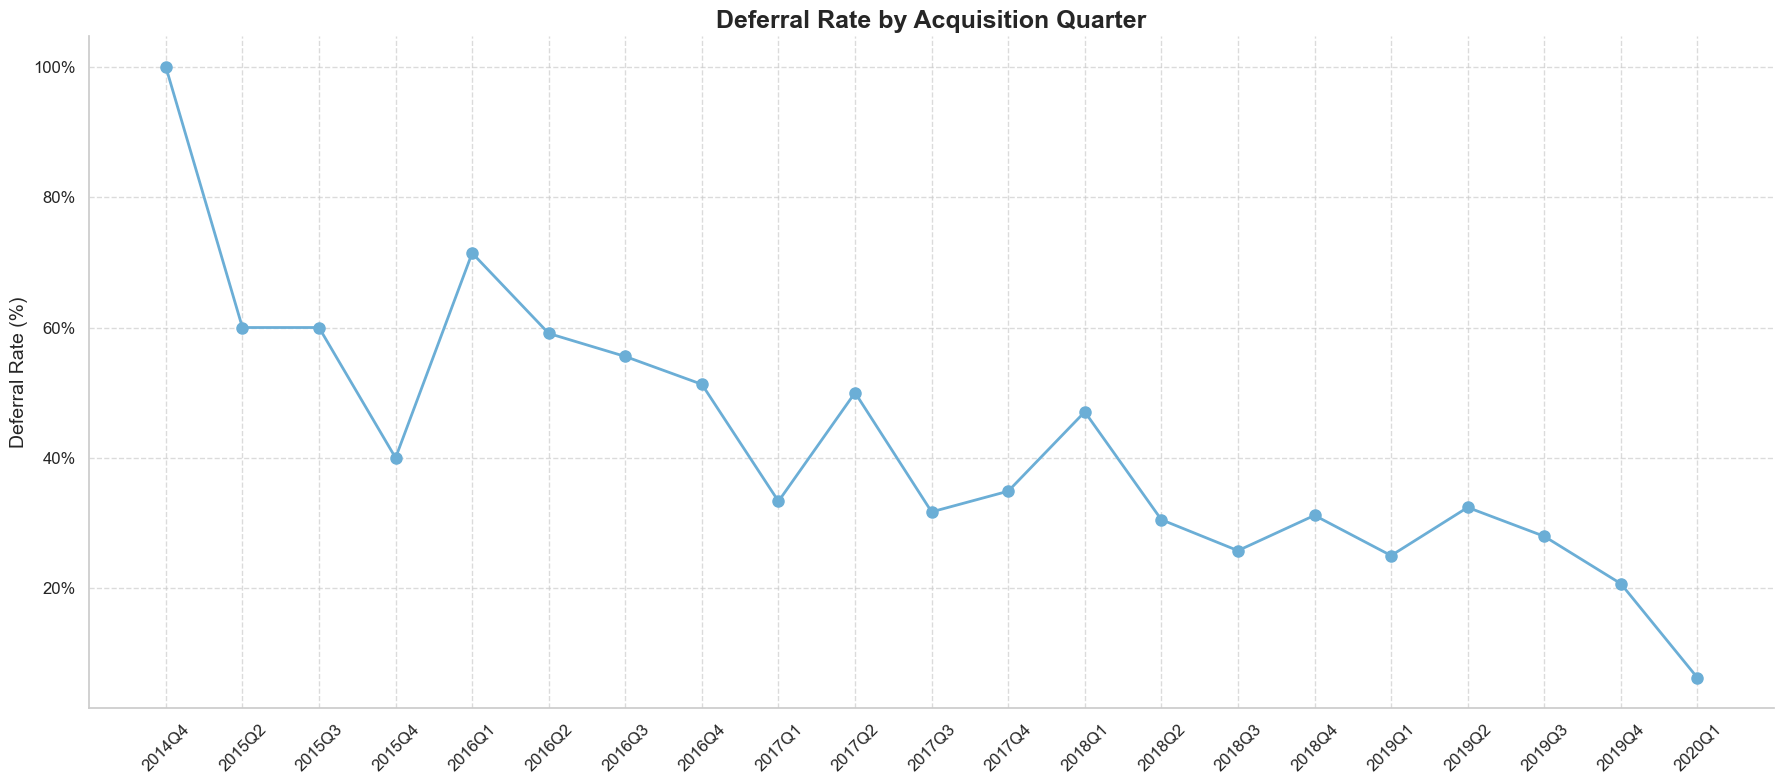

In [ ]:
# Set a clean style
sns.set(style="whitegrid")

# Create figure with larger size
plt.figure(figsize=(18,8))

# Plot line chart with markers
plt.plot(
    deferral_by_quarter['acq_quarter'].astype(str), 
    deferral_by_quarter['deferral_rate'], 
    marker='o', 
    linewidth=2, 
    markersize=8,
    color='#6baed6'
)

# Title and axis labels with larger fonts
plt.title('Deferral Rate by Acquisition Quarter', fontsize=18, fontweight='bold')
plt.xlabel('', fontsize=14)
plt.ylabel('Deferral Rate (%)', fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()

In [12]:
df_transactions['date_created'] = pd.to_datetime(df_transactions['date_created'], errors='coerce')
df_transactions['trans_month'] = df_transactions['date_created'].dt.to_period('M')
monthly_users = (
    df_transactions.groupby('trans_month')['user']
    .nunique()
    .reset_index(name='total_users')
)

# Keep only users with extension
ext_users = df_extension[df_extension['used_extension'] == True]['user'].unique()

monthly_ext_users = (
    df_transactions[df_transactions['user'].isin(ext_users)]
    .groupby('trans_month')['user']
    .nunique()
    .reset_index(name='users_with_extension')
)

monthly_deferral = monthly_users.merge(monthly_ext_users, on='trans_month', how='left')
monthly_deferral['users_with_extension'] = monthly_deferral['users_with_extension'].fillna(0)

monthly_deferral['deferral_rate'] = (
    monthly_deferral['users_with_extension'] / monthly_deferral['total_users']
)

print(monthly_deferral.head())

  trans_month  total_users  users_with_extension  deferral_rate
0     2013-12            4                   2.0           0.50
1     2014-01            1                   0.0           0.00
2     2014-02            2                   1.0           0.50
3     2014-03            1                   1.0           1.00
4     2014-04            4                   1.0           0.25


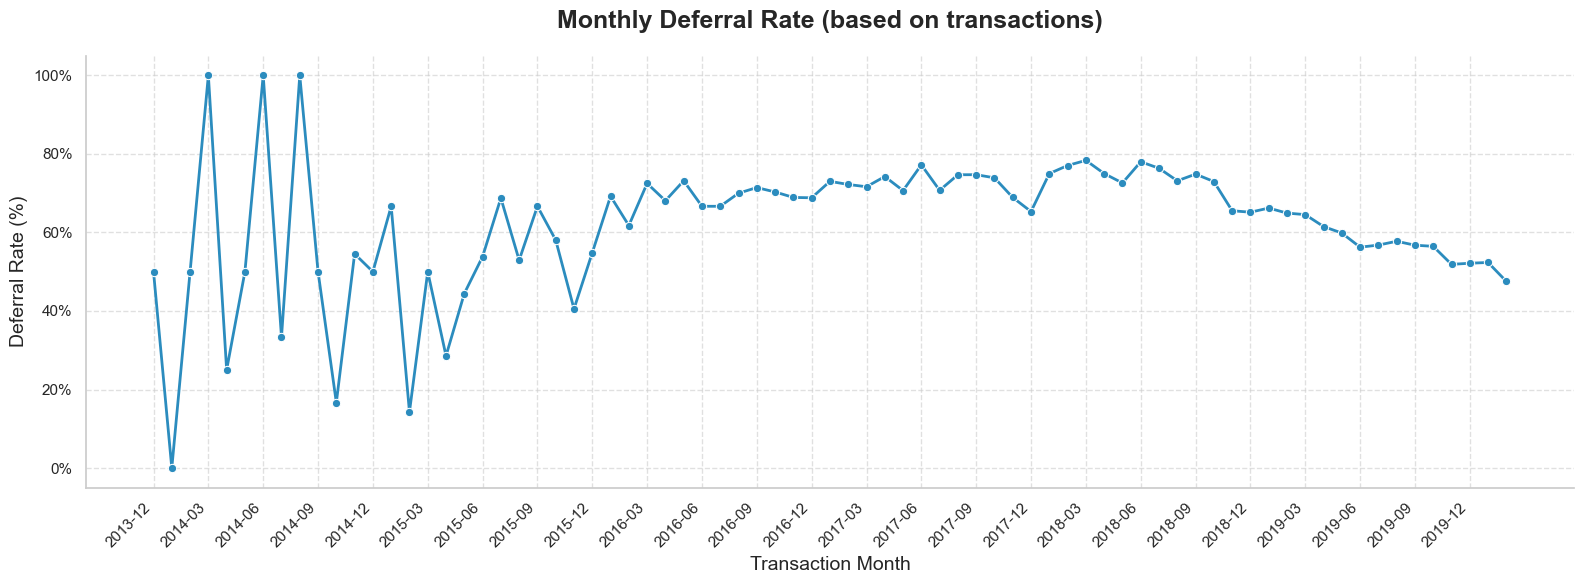

In [13]:
plt.figure(figsize=(16,6))

# Line chart for deferral rate
sns.lineplot(
    data=monthly_deferral,
    x=monthly_deferral['trans_month'].astype(str),
    y='deferral_rate',
    marker='o',
    linewidth=2,
    markersize=6,
    color='#2b8cbe'
)

# Title and labels
plt.title('Monthly Deferral Rate (based on transactions)', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Deferral Rate (%)', fontsize=14)
plt.xlabel('Transaction Month', fontsize=14)

# X-axis: show only every 3rd month to avoid clutter
plt.xticks(ticks=range(0, len(monthly_deferral), 3),
           labels=monthly_deferral['trans_month'].astype(str)[::3],
           rotation=45, ha='right', fontsize=11)

# Format y-axis as %
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Grid & borders
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()

In [39]:
# Merge base and extension data
df_merged = df_extension.merge(
    df_base[['user', 'source', 'acq_quarter']],
    on='user',
    how='left'
)

# Ensure source is clean
df_merged['source'] = df_merged['source'].str.strip()

# Group by quarter and channel
deferral_table = (
    df_merged.groupby(['acq_quarter', 'source'])
    .agg(
        total_users=('user', 'nunique'),
        users_with_extension=('used_extension', lambda x: (x==True).sum())
    )
    .reset_index()
)

# 3. Calculate deferral rate
deferral_table['deferral_rate'] = (
    deferral_table['users_with_extension'] / deferral_table['total_users']
)

# 4. Pivot table: quarters as rows, channels as columns
deferral_table_pivot = deferral_table.pivot(
    index='acq_quarter',
    columns='source',
    values='deferral_rate'
)

# 5. Display nicely in Jupyter as percentages
deferral_table_pivot.style.format("{:.2%}")

clean_table = deferral_table_pivot.fillna(0)

clean_table.style.format("{:.0%}")

source,affiliate,ambassadors,now,performance+organic,referral,split
acq_quarter,,,,,,
2014Q4,0%,0%,100%,0%,0%,0%
2015Q2,0%,0%,56%,100%,0%,0%
2015Q3,0%,0%,73%,25%,0%,0%
2015Q4,0%,0%,40%,40%,0%,0%
2016Q1,0%,0%,70%,100%,0%,0%
2016Q2,0%,0%,60%,50%,0%,0%
2016Q3,0%,0%,59%,0%,0%,0%
2016Q4,0%,0%,48%,67%,0%,0%
2017Q1,0%,0%,33%,33%,0%,0%
